In [47]:
import cv2
import numpy as np
from pandas import DataFrame, read_csv
from matplotlib import pyplot as plt
from shutil import copy2
from tensorflow.keras.layers import (Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten,
                                     GlobalMaxPooling2D, LeakyReLU, concatenate, Dropout)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from os.path import isfile

In [48]:
y_filename='training_solutions_rev1.csv'
y = read_csv(y_filename, index_col=0)[['Class1.1','Class1.2','Class1.3']]

In [49]:
def isolate(image, feather=(30,30)):
    image = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.blur(gray,(5,5))

    blur = cv2.blur(image,(30,30))

    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)

    ret, markers = cv2.connectedComponents(thresh)
    markers = cv2.watershed(blur,markers)
    centergroup= markers[212,212]

    mask = np.array(markers).astype(np.uint8)
    mask[:,:]=0
    mask[markers == centergroup] = 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, feather)
    mask = cv2.dilate(mask,kernel,iterations = 1)
    mask = cv2.blur(mask, feather).astype(float)

    for i in range(3):
        image[:,:,i] = (image[:,:,i] * mask/255.0).astype(np.uint8)
    return image

In [50]:
def crop(image, size=(128,128)):
    centerx = image.shape[0]//2
    centery = image.shape[1]//2
    hheight = size[0]//2
    hwidth = size[1]//2
    return image[centerx-hwidth:centerx+hwidth, centery-hheight:centery+hheight]

In [51]:
def black_crop(image):
    mask = image[:,:,1].copy()
    mask[:,:]=255
    mask[image[:,:,1]==0]=0
    
    minx=413
    maxx=0
    maskx=mask.sum(axis=1)
    
    for i,val in enumerate(maskx):
        if val!=0 and i < minx:
            minx = i
        if val!=0 and i > maxx:
            maxx = i
    
    miny=413
    maxy=0
    masky=mask.sum(axis=0)
    for i,val in enumerate(masky):
        if val!=0 and i < miny:
            miny = i
        if val!=0 and i > maxy:
            maxy = i
    centerx = (minx+maxx)//2
    centery = (miny+maxy)//2
    image = image[centerx-128:centerx+128, centery-128:centery+128]
    #image = image[minx:maxx, miny:maxy]
    return image

In [52]:
def separate_Lab(image):
    imageLab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    #plt.imshow(imageLab)
    imageL = cv2.resize(imageLab[:,:,0], (128,128))
    imageA = cv2.resize(imageLab[:,:,1], (64,64))
    imageB = cv2.resize(imageLab[:,:,2], (64,64))
    return [imageL, imageA, imageB]

In [53]:
def get_model():
    return Sequential([
        Input(shape=(256,256,3)),
        Conv2D(128,(3,3),input_shape=(256,256,3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64,(3,3)),
        Activation('relu'),
        GlobalMaxPooling2D(),
        Dense(64),
        Activation('relu'),
        Dense(3),
        Activation('sigmoid')
])

In [54]:
def create_con2d(image, shape, filters):
    model = Conv2D(filters, (3, 3), padding='same',  input_shape=shape)(image)
    #model = Conv2D(filters//2, (3, 3), padding='same', input_shape=shape)(image)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2), padding='same')(model)
    return model

def create_dense(model, size):
    #model = Dropout(0.25)(model)
    model = Dense(64)(model)
    model = Activation('relu')(model)
    return model
    
def get_fun_model():
    shape_L = (128,128,1)
    shape_a = (64,64,1)
    shape_b = (64,64,1)
    
    input_L = Input(shape=shape_L)
    input_a = Input(shape=shape_a)
    input_b = Input(shape=shape_b)
    
    conv_L = create_con2d(input_L, shape_L, 4)

    model = concatenate([conv_L, input_a, input_b])
    
    model = create_con2d(model,(64,64,1), 4)
    model = create_con2d(model,(32,32,1), 4)
    model = create_con2d(model,(16,16,1), 2)
        
    model = Flatten()(model)
    
    model = create_dense(model, 16)
    model = create_dense(model, 8)
    
    model = Dense(3)(model)
    #output = Activation('sigmoid')(model)
    output = Activation('softmax')(model)
    
    model = Model(inputs=[input_L, input_a, input_b], outputs=[output])
    
    return model

In [55]:
y_train, y_test = train_test_split(y, test_size=0.2)

In [16]:
sample_size=1000

y_batch = y_train[0:sample_size]
x_batch = []
dir = './images_training_rev1/'
for i in range(sample_size):
    filename = dir + str(y.index[i]) + '.jpg'
    img =  cv2.imread(filename)
    x_batch.append(black_crop(isolate(img))/255.0)

y_batch = y_batch[['Class1.1','Class1.2','Class1.3']].to_numpy().astype(np.float16)
x_batch = np.asarray(x_batch).astype(np.float16)

In [56]:
sample_size=1000

y_batch = y_train[0:sample_size]
x_batchL = []
x_batcha = []
x_batchb = []
dir = './images_training_rev1/'
for i in range(sample_size):
    filename = dir + str(y.index[i]) + '.jpg'
    img =  cv2.imread(filename)
    images = separate_Lab(black_crop(isolate(img)))
    # print(images[2].shape)
    x_batchL.append(images[0]/255)
    x_batcha.append(images[1]/255)
    x_batchb.append(images[2]/255)

y_batch = y_batch[['Class1.1','Class1.2','Class1.3']].to_numpy().astype(np.float16)
x_batchL = np.asarray(x_batchL).astype(np.float16).reshape(sample_size,128,128,1)
x_batcha = np.asarray(x_batcha).astype(np.float16).reshape(sample_size,64,64,1)
x_batchb = np.asarray(x_batchb).astype(np.float16).reshape(sample_size,64,64,1)



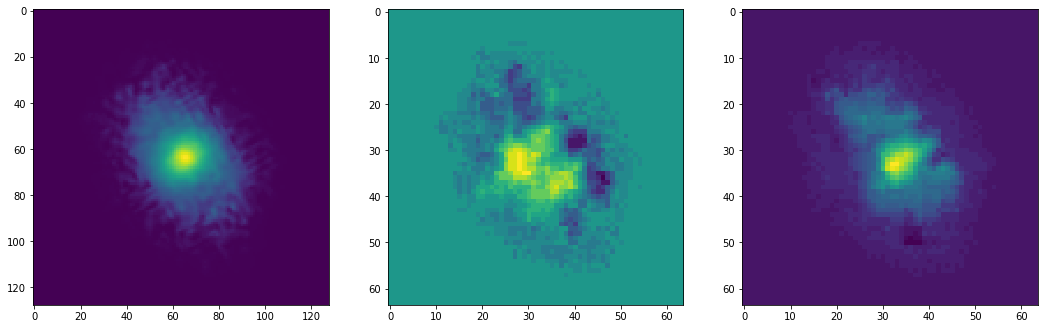

In [57]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow((x_batchL[5,:,:,0]*255).astype(np.uint8))
plt.subplot(1,3,2)
plt.imshow((x_batcha[5,:,:,0]*255).astype(np.uint8))
plt.subplot(1,3,3)
plt.imshow((x_batchb[5,:,:,0]*255).astype(np.uint8))
plt.show()

In [11]:
loss='categorical_crossentropy'
LEARNING_RATE = 0.01
BATCH_SIZE = 20 # computing the loss over the whole dataset
EPOCHS = 3
model = get_model()
model.compile(loss=loss, optimizer='adamax', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 128)     3584      
_________________________________________________________________
activation (Activation)      (None, 254, 254, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     147584    
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 128)     0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3

In [245]:
with tf.device('/device:CPU:0'):
    history = model.fit(x_batch,y_batch, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Train on 1000 samples
Epoch 1/3
1000/1000 [==============================] - 127s 127ms/sample - loss: 0.8055 - accuracy: 0.5560
Epoch 2/3
1000/1000 [==============================] - 125s 125ms/sample - loss: 0.7806 - accuracy: 0.5690
Epoch 3/3
1000/1000 [==============================] - 126s 126ms/sample - loss: 0.7804 - accuracy: 0.5690


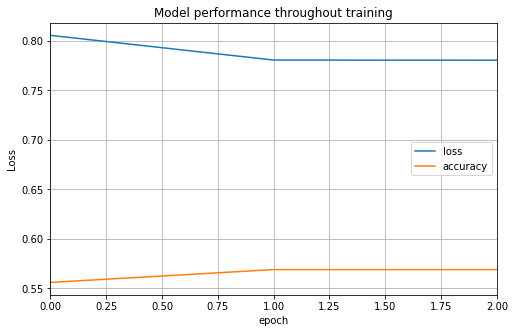

In [246]:
DataFrame(history.history).plot(figsize=(8, 5))#, logy=True)
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [247]:
with tf.device('/device:CPU:0'):
    y_pred = model.predict(x_batch.astype(np.float16))

In [248]:
y_pred, y_batch

(array([[0.7652117 , 0.94180405, 0.02477583],
        [0.7521488 , 0.9315028 , 0.03112078],
        [0.77038836, 0.9459208 , 0.02225083],
        ...,
        [0.7466464 , 0.9305258 , 0.03124222],
        [0.7299855 , 0.9083406 , 0.04599613],
        [0.73018444, 0.90871596, 0.04623601]], dtype=float32),
 array([[0.361   , 0.639   , 0.      ],
        [0.2094  , 0.7744  , 0.0162  ],
        [0.1542  , 0.8433  , 0.002571],
        ...,
        [0.1844  , 0.8086  , 0.00706 ],
        [0.3684  , 0.538   , 0.09344 ],
        [0.2002  , 0.7954  , 0.004326]], dtype=float16))

In [63]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

loss='categorical_crossentropy'
LEARNING_RATE = 0.01
BATCH_SIZE = 50 # computing the loss over the whole dataset
EPOCHS = 50
filename = './CNN-checkpoint-model.hdf5'
callback = ModelCheckpoint(filename, monitor='loss', verbose=0,
                             save_best_only=True, save_weights_only=False,
                             mode='auto', save_freq=sample_size)
if isfile(filename):
    model = load_model(filename, compile=False)
else:
    model = get_fun_model()
model.compile(loss=loss, optimizer='adamax', metrics=[root_mean_squared_error])

In [64]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 4)  40          input_4[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 128, 128, 4)  0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 4)    0           activation_7[0][0]               
____________________________________________________________________________________________

In [65]:
with tf.device('/device:CPU:0'):
    history = model.fit([x_batchL, x_batcha, x_batchb],y_batch, epochs=EPOCHS,
                        batch_size=BATCH_SIZE, verbose=1, callbacks=[callback])

Train on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.7841 - root_mean_squared_error: 0.2332
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.7832 - root_mean_squared_error: 0.2324
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.7842 - root_mean_squared_error: 0.2331
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.7827 - root_mean_squared_error: 0.2323
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.7829 - root_mean_squared_error: 0.2326
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.7827 - root_mean_squared_error: 0.2326
Epoch 7/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.7826 - root_mean_squared_error: 0.2323
Epoch 8/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.7829 - root_mean_squared_error: 0.2324
Epoch 9/50
1000/1000 [====

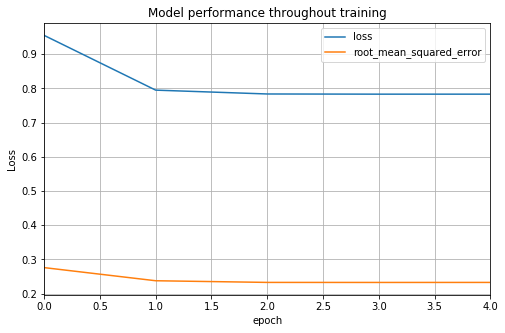

In [61]:
DataFrame(history.history).plot(figsize=(8, 5))#, logy=True)
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [62]:
with tf.device('/device:CPU:0'):
    y_pred = model.predict([x_batchL, x_batcha, x_batchb])
y_pred, y_batch

(array([[0.407065  , 0.568349  , 0.02458595],
        [0.40588635, 0.57023543, 0.0238782 ],
        [0.40647575, 0.5704108 , 0.0231135 ],
        ...,
        [0.40677962, 0.56886333, 0.02435705],
        [0.4084596 , 0.5657409 , 0.02579955],
        [0.40786824, 0.56678236, 0.0253494 ]], dtype=float32),
 array([[0.2874  , 0.699   , 0.013664],
        [0.548   , 0.4353  , 0.01677 ],
        [0.03806 , 0.959   , 0.003084],
        ...,
        [0.81    , 0.095   , 0.095   ],
        [0.6562  , 0.2139  , 0.1296  ],
        [0.1875  , 0.8125  , 0.      ]], dtype=float16))